In [15]:
import pandas as pd
from sklearn.decomposition._pca import PCA
import numpy as np
from factor_analyzer import FactorAnalyzer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### Averaging, PCA and EFA simulations

In [16]:
num_var = 7

In [17]:
factors = pd.read_csv('factors.csv')

if num_var == 7:
    variables = factors
else:
    variables = factors[['VSQ(z)', 'Total Chi(z)', 'Aura(z)']]

Bootstrapping

In [87]:
pca = PCA(n_components=3)
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
num_bootstrap_sample = 20000

v_num = 0

fa_results, pca_results, mean_results, loadings, components = [], [], [], [], []
flat_avg_obs, pca_obs, efa_obs = [], [], []
for i in tqdm(range(num_bootstrap_sample)):
    # get my bootstrapped sample
    sample = variables.sample(n=len(variables), replace=True)
    sample = sample - sample.mean()

    # firstly run PCA
    pca_data = pca.fit_transform(sample)
    pca_obs.append(pca_data[:, v_num])
    pca_results.append(np.var(pca_data, axis=0).tolist())
    components.append(pca.components_)
    
    # generata FA results
    fa.fit(sample)
    loadings.append(fa.loadings_)
    scores = fa.transform(sample)
    fa_results.append(np.var(scores, axis=0).tolist())
    efa_obs.append(scores[:, v_num])

    # generate mean results
    if num_var == 7:
        discomfort = sample['Discomfort index (z)'].var()
        visual_stress = sample[['VSQ(z)', 'Total Chi(z)', 'Aura(z)']].mean(axis=1).var()
        headache = sample[['Headache Duration', 'Headache Intensity(z)', 'Headache Frequency (z)']].mean(axis=1).var()
        mean_results.append([visual_stress, headache, discomfort])
        flat_avg_obs.append(sample[['VSQ(z)', 'Total Chi(z)', 'Aura(z)']].mean(axis=1))
    else:
        mean_results.append(sample.var().tolist())    

100%|██████████| 20000/20000 [00:07<00:00, 2820.21it/s]


### Data Analysis

Investigating appropriate components/factors and assigning them properly

In [75]:
# average loadings of PCA
pd.DataFrame(np.mean(components, axis=0).T, index=variables.columns, columns=['PC1 (Headache)', 'PC2 (Visual Stress)', 'PC3 (Discomfort)'])

,PC1 (Headache),PC2 (Visual Stress),PC3 (Discomfort)
VSQ(z),-0.015682,0.347814,0.163539
Total Chi(z),-0.015700,0.473698,-0.017893
Aura(z),-0.028961,0.458457,0.089400
Headache Duration,0.993626,0.007383,0.014779
Headache Intensity(z),0.032554,0.377834,-0.127649
Headache Frequency (z),0.036114,0.378520,-0.107376
Discomfort index (z),-0.003380,0.160584,0.386617


In [76]:
# average loadings of PCA
pd.DataFrame(np.mean(loadings, axis=0), index=variables.columns, columns=['F1 (Visaul Stress)', 'F2 (Headache)', 'F3 (Discomfort)'])

,F1 (Visaul Stress),F2 (Headache),F3 (Discomfort)
VSQ(z),0.324783,0.170024,0.242123
Total Chi(z),0.677464,0.213355,0.079121
Aura(z),0.629601,0.218352,0.194662
Headache Duration,-0.039902,0.317811,0.081000
Headache Intensity(z),0.442945,0.384577,0.140003
Headache Frequency (z),0.514243,0.407108,0.119694
Discomfort index (z),0.069667,0.151932,0.406506


Investigating variances across variables and for each variable.

In [71]:
avg_var_flat_avg = np.round(np.mean(mean_results, axis=0),3)
avg_var_pca = np.round(np.mean(pca_results, axis=0),3)
avg_var_efa = np.round(np.mean(fa_results, axis=0),3)

print('Three dimension variances')
print(f' Mean Variance Flat Averaging {avg_var_flat_avg}')
print(f' Mean Variance PCA {avg_var_pca}')
print(f' Mean Variance EFA {avg_var_efa}')

print('Sum of variance across three dimensions')
print(f' Mean Variance Flat Averaging {np.round(avg_var_flat_avg.sum(),3)}')
print(f' Mean Variance PCA {np.round(avg_var_pca.sum(),3)}')
print(f' Mean Variance EFA {np.round(avg_var_efa.sum(),3)}')

Three dimension variances
 Mean Variance Flat Averaging [0.616 8.828 0.972]
 Mean Variance PCA [65.447  2.506  1.091]
 Mean Variance EFA [0.915 0.911 0.879]
Sum of variance across three dimensions
 Mean Variance Flat Averaging 10.416
 Mean Variance PCA 69.044
 Mean Variance EFA 2.705


Look at covariance matricies of the first principal component, EFA and averages.

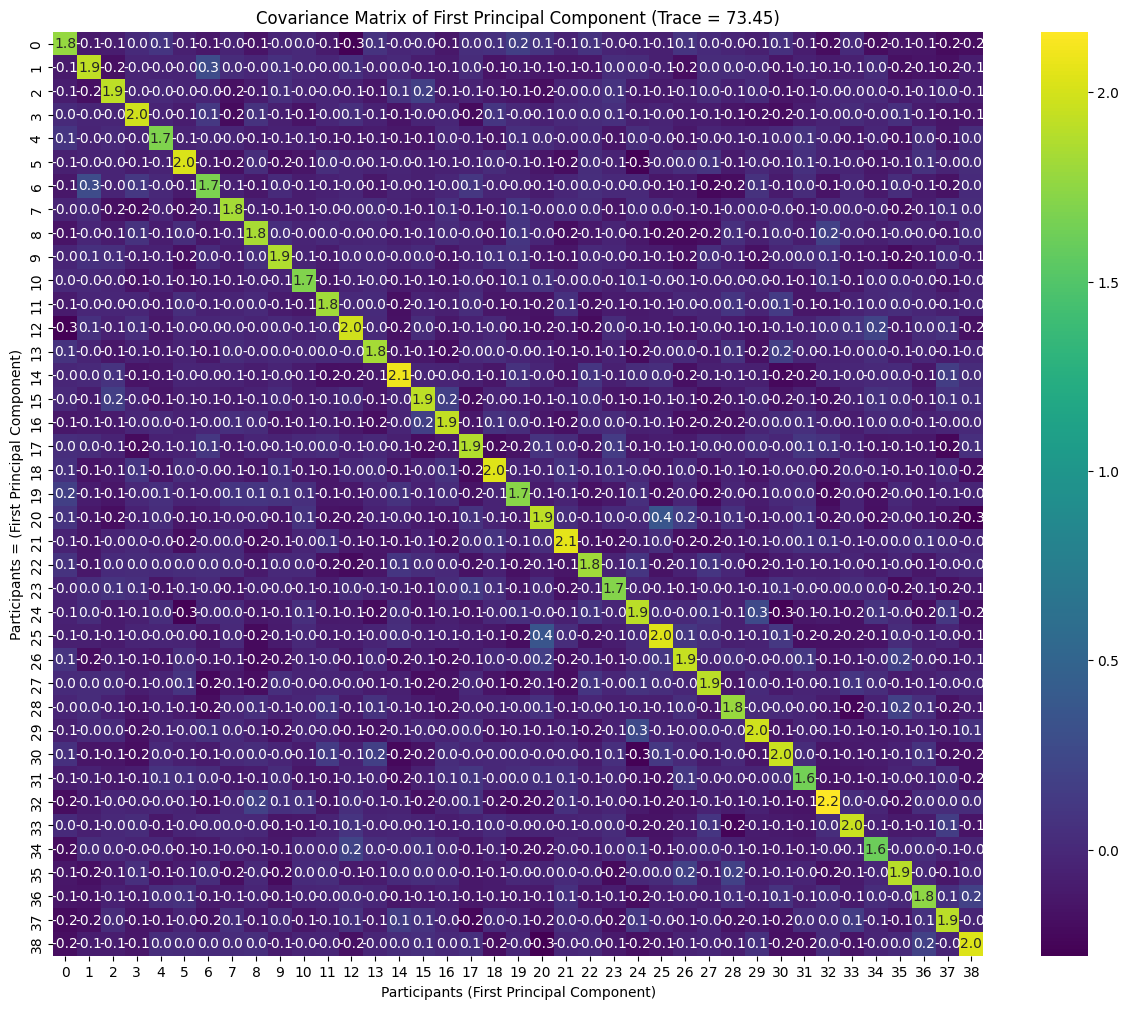

In [13]:
pca_obs_reshaped = np.array(pca_obs).T
covariance_matrix = np.round(np.cov(pca_obs_reshaped),2)
plt.figure(figsize=(15, 12))
sns.heatmap(covariance_matrix, cmap='viridis', annot=True, fmt=".1f", cbar=True)
plt.title(f'Covariance Matrix of First Principal Component (Trace = {np.round(np.trace(covariance_matrix),2)})')
plt.xlabel('Participants (First Principal Component)')
plt.ylabel('Participants = (First Principal Component)')
plt.show()

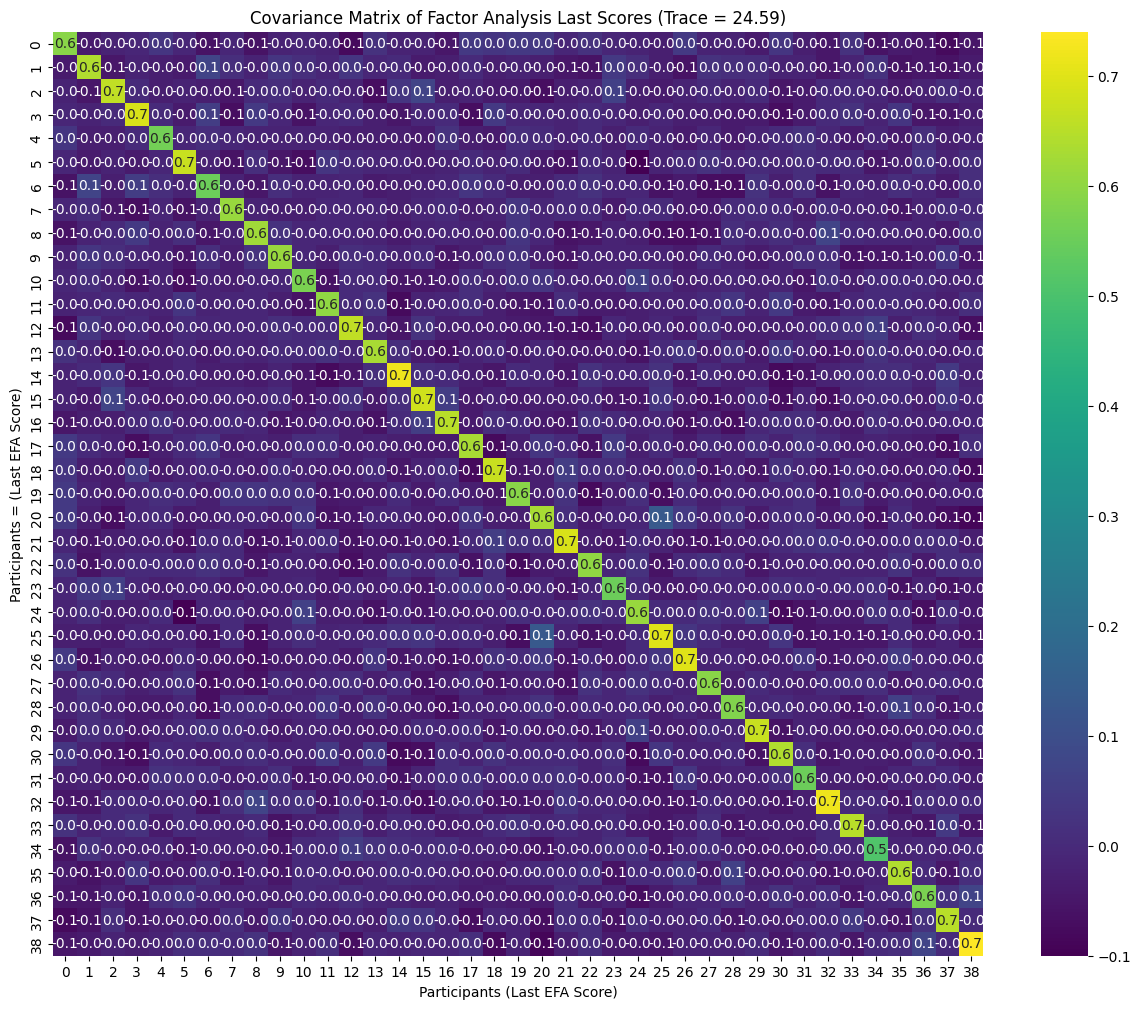

In [14]:
efa_obs = np.array(efa_obs).T
covariance_matrix = np.round(np.cov(efa_obs),2)
plt.figure(figsize=(15, 12))
sns.heatmap(covariance_matrix, cmap='viridis', annot=True, fmt=".1f", cbar=True)
plt.title(f'Covariance Matrix of Factor Analysis Last Scores (Trace = {np.round(np.trace(covariance_matrix),2)})')
plt.xlabel('Participants (Last EFA Score)')
plt.ylabel('Participants = (Last EFA Score)')
plt.show()

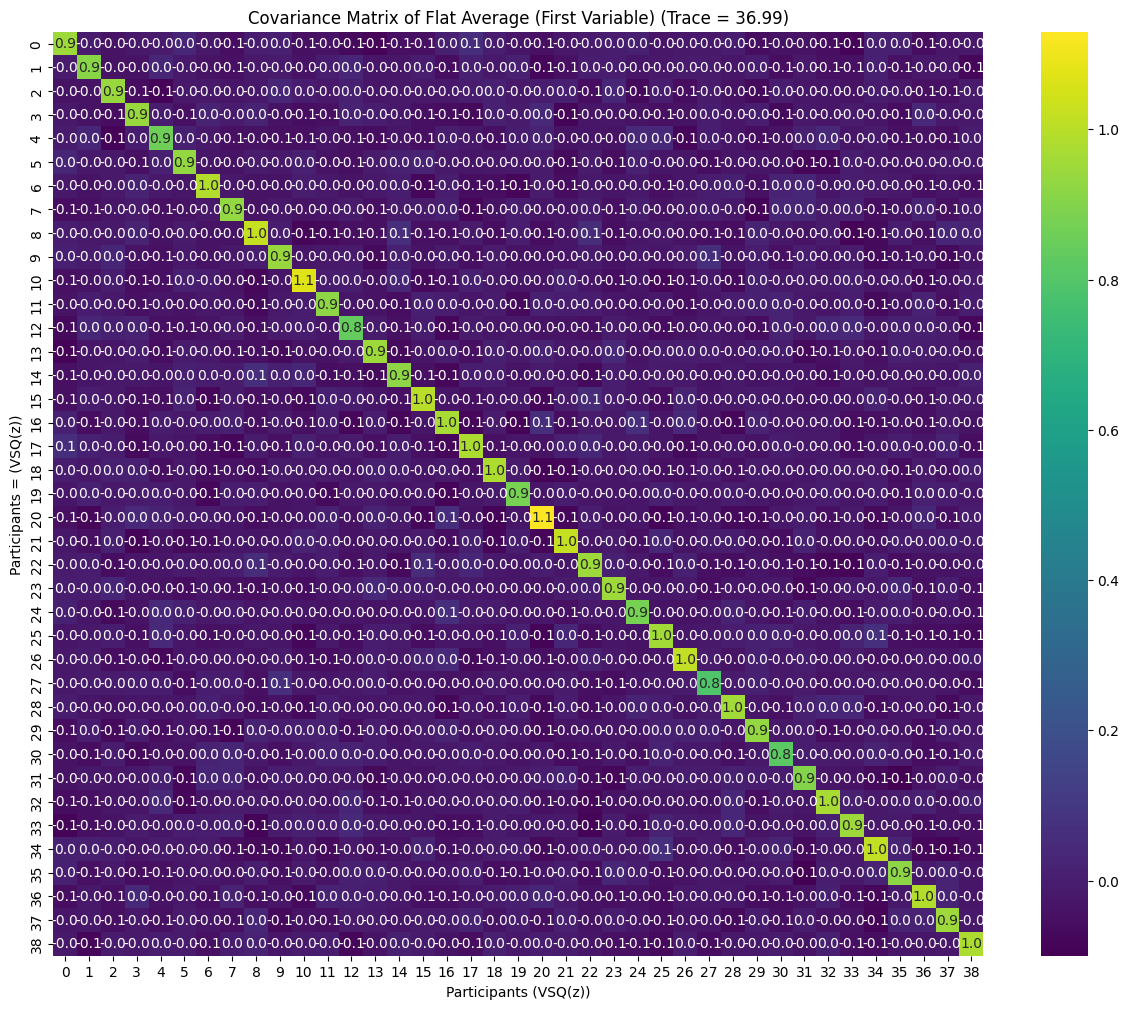

In [91]:
flat_avg_obs = np.array(flat_avg_obs).T
covariance_matrix = np.round(np.cov(flat_avg_obs),2)
plt.figure(figsize=(15, 12))
sns.heatmap(covariance_matrix, cmap='viridis', annot=True, fmt=".1f", cbar=True)
plt.title(f'Covariance Matrix of Flat Average (First Variable) (Trace = {np.round(np.trace(covariance_matrix),2)})')
plt.xlabel('Participants (VSQ(z))')
plt.ylabel('Participants = (VSQ(z))')
plt.show()

PCA Component Matricies

In [110]:
import plotly.graph_objects as go

data = fa_results

# Unpack the data
x = [item[0] for item in data]
y = [item[1] for item in data]
z = [item[2] for item in data]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=z,                # set color to an arry/list of desired values
        colorscale='Viridis',    # choose a colorscale
        opacity=0.8
    )
)])

# Set the size of the plot
fig.update_layout(
    autosize=False,
    width=1600,   # Set the width of the plot
    height=1200,  # Set the height of the plot
    scene = dict(
        xaxis_title='1',
        yaxis_title='2',
        zaxis_title='3'
    ),
    title='50,000 Bootstrapped Iterations'
)


# Show the plot
fig.show()


### Appendix

Old bootstrapping method

In [ ]:
pca = PCA(n_components=3)
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
num_bootstrap_sample = 50

fa_results, pca_results, mean_results, loadings, components = [], [], [], [], []
for i in range(num_bootstrap_sample):
    # get my bootstrapped sample
    sample = variables.sample(n=len(variables), replace=True)
    sample = sample - sample.mean()

    # firstly run PCA
    pca_data = pca.fit_transform(sample)
    pca_results.append(np.mean(pca_data, axis=0).tolist())
    components.append(pca.components_)  

    # generata FA results
    fa.fit(sample)
    loadings.append(fa.loadings_)
    scores = fa.transform(sample)
    fa_results.append(np.mean(scores, axis=0).tolist())

    # generate mean results
    if num_var == 7:
        discomfort = sample['Discomfort index (z)'].mean()
        visual_stress = sample[['VSQ(z)', 'Total Chi(z)', 'Aura(z)']].mean().mean()
        headache = sample[['Headache Duration', 'Headache Intensity(z)', 'Headache Frequency (z)']].mean().mean()
        mean_results.append([visual_stress, headache, discomfort])
    else:
        mean_results.append(sample.mean().tolist())